In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import os 
import pickle
import pandas as pd 
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Load data set

In [2]:
 
path = "myData" # folder with all the class folders
labelFile = 'labels.csv' # file with all names of classes
batch_size_val=50  # how many to process together
steps_per_epoch_val=2000
epochs_val=10
imageDimesions = (32,32,3)
testRatio = 0.2    # if 1000 images split will 200 for testing
validationRatio = 0.2 # if 1000 images 20% of remaining 800 will be 160 for validation
###################################################

############################### Importing of the Images
count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:",len(myList))
noOfClasses=len(myList)
print("Importing Classes.....")
for x in range (0,len(myList)):
    myPicList = os.listdir(path+"/"+str(count))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(count)+"/"+y)
        images.append(curImg)
        classNo.append(count)
    print(count, end =" ")
    count +=1
print(" ")
images = np.array(images)
classNo = np.array(classNo)


Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


### Split the data

In [3]:
############################### Split Data
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)
 
# X_train = ARRAY OF IMAGES TO TRAIN
# y_train = CORRESPONDING CLASS ID

In [4]:
############################### TO CHECK IF NUMBER OF IMAGES MATCHES TO NUMBER OF LABELS FOR EACH DATA SET
print("Data Shapes")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
print("Test",end = "");print(X_test.shape,y_test.shape)
assert(X_train.shape[0]==y_train.shape[0]), "The number of images in not equal to the number of lables in training set"
assert(X_validation.shape[0]==y_validation.shape[0]), "The number of images in not equal to the number of lables in validation set"
assert(X_test.shape[0]==y_test.shape[0]), "The number of images in not equal to the number of lables in test set"
assert(X_train.shape[1:]==(imageDimesions))," The dimesions of the Training images are wrong "
assert(X_validation.shape[1:]==(imageDimesions))," The dimesionas of the Validation images are wrong "
assert(X_test.shape[1:]==(imageDimesions))," The dimesionas of the Test images are wrong"
 

Data Shapes
Train(22271, 32, 32, 3) (22271,)
Validation(5568, 32, 32, 3) (5568,)
Test(6960, 32, 32, 3) (6960,)


In [5]:
############################### READ CSV FILE
data=pd.read_csv(labelFile)
print("data shape ",data.shape,type(data))

data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


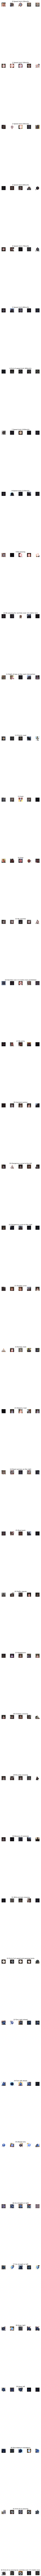

In [6]:
############################### DISPLAY SOME SAMPLES IMAGES  OF ALL THE CLASSES
num_of_samples = []
cols = 5
num_classes = noOfClasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 300))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)- 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+ "-"+row["Name"])
            num_of_samples.append(len(x_selected))
 

[114, 1277, 1306, 820, 1147, 1102, 253, 791, 822, 833, 1148, 752, 1166, 1206, 444, 351, 233, 629, 676, 116, 191, 173, 208, 307, 156, 866, 335, 134, 303, 165, 256, 455, 135, 387, 236, 677, 208, 107, 1165, 172, 194, 122, 133]


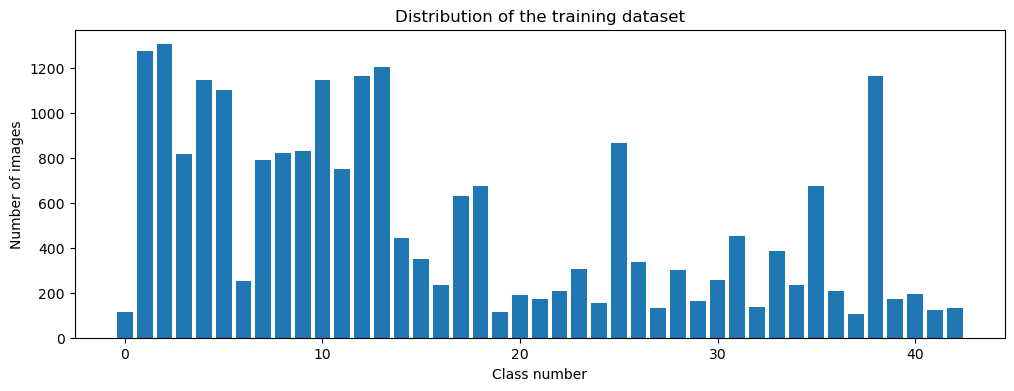

In [7]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

# Preprocessing the images

In [8]:
def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img =cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)     # CONVERT TO GRAYSCALE
    img = equalize(img)      # STANDARDIZE THE LIGHTING IN AN IMAGE
    img = img/255            # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    return img
 
X_train=np.array(list(map(preprocessing,X_train)))  # TO IRETATE AND PREPROCESS ALL IMAGES
X_validation=np.array(list(map(preprocessing,X_validation)))
X_test=np.array(list(map(preprocessing,X_test)))

In [9]:
# Add epoch of 1
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
 

In [10]:
dataGen= ImageDataGenerator(width_shift_range=0.1,   # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                            height_shift_range=0.1,
                            zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                            shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                            rotation_range=10)  # DEGREES
dataGen.fit(X_train)
batches= dataGen.flow(X_train,y_train,batch_size=20)  # REQUESTING DATA GENRATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREAED EACH TIME ITS CALLED
X_batch,y_batch = next(batches)

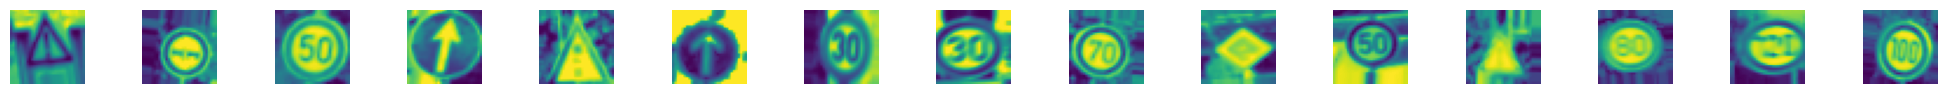

In [11]:
fig,axs=plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimesions[0],imageDimesions[1]))
    axs[i].axis('off')
plt.show()
 

In [12]:
y_train = to_categorical(y_train,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)

# Build the model

In [13]:
def myModel():
    no_Of_Filters=60
    size_of_Filter=(5,5) # THIS IS THE KERNEL THAT MOVE AROUND THE IMAGE TO GET THE FEATURES.
                         # THIS WOULD REMOVE 2 PIXELS FROM EACH BORDER WHEN USING 32 32 IMAGE
    size_of_Filter2=(3,3)
    size_of_pool=(2,2)  # SCALE DOWN ALL FEATURE MAP TO GERNALIZE MORE, TO REDUCE OVERFITTING
    no_Of_Nodes = 500   # NO. OF NODES IN HIDDEN LAYERS
    model= Sequential()
    model.add((Conv2D(no_Of_Filters,size_of_Filter,input_shape=(imageDimesions[0],imageDimesions[1],1),activation='relu')))  # ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool)) # DOES NOT EFFECT THE DEPTH/NO OF FILTERS
 
    model.add((Conv2D(no_Of_Filters//2, size_of_Filter2,activation='relu')))
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))
 
    model.add(Flatten())
    model.add(Dense(no_Of_Nodes,activation='relu'))
    model.add(Dropout(0.5)) # INPUTS NODES TO DROP WITH EACH UPDATE 1 ALL 0 NONE
    model.add(Dense(noOfClasses,activation='softmax')) # OUTPUT LAYER
    # COMPILE MODEL
    model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [14]:
model = myModel()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

In [15]:
history=model.fit_generator(dataGen.flow(X_train,y_train,batch_size=batch_size_val),steps_per_epoch=len(X_train)//batch_size_val,epochs=30,validation_data=(X_validation,y_validation),shuffle=1)
 

c:\Users\Mohamed Essam\anaconda3\envs\py3713\lib\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/30
445/445 [==============================] - 58s 127ms/step - loss: 2.6280 - accuracy: 0.2704 - val_loss: 0.9061 - val_accuracy: 0.7060
Epoch 2/30
445/445 [==============================] - 106s 239ms/step - loss: 1.2649 - accuracy: 0.6109 - val_loss: 0.3654 - val_accuracy: 0.9113
Epoch 3/30
445/445 [==============================] - 93s 209ms/step - loss: 0.8339 - accuracy: 0.7458 - val_loss: 0.1955 - val_accuracy: 0.9423
Epoch 4/30
445/445 [==============================] - 103s 231ms/step - loss: 0.6453 - accuracy: 0.8002 - val_loss: 0.1268 - val_accuracy: 0.9648
Epoch 5/30
445/445 [==============================] - 114s 256ms/step - loss: 0.5262 - accuracy: 0.8346 - val_loss: 0.0813 - val_accuracy: 0.9799
Epoch 6/30
445/445 [==============================] - 126s 284ms/step - loss: 0.4442 - accuracy: 0.8610 - val_loss: 0.0752 - val_accuracy: 0.9767
Epoch 7/30
445/445 [==============================] - 80s 179ms/step - loss: 0.4106 - accuracy: 0.8731 - val_loss: 0.0843 - va

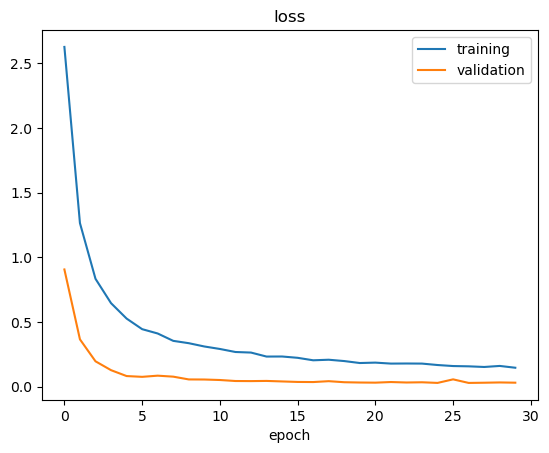

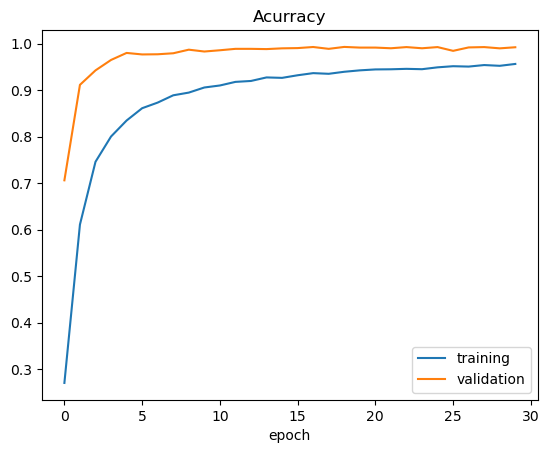

Test Score: 0.020845385268330574
Test Accuracy: 0.995258629322052


In [18]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score =model.evaluate(X_test,y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])
 

In [19]:
pickle_out= open("model_trained.p","wb")  
pickle.dump(model,pickle_out)
pickle_out.close()

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\conv2d_2
......vars
.........0
.........1
...layers\conv2d_3
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\flatten
......vars
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........23
.........24
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File